<a href="https://colab.research.google.com/github/Hitesh1912/AuthentiFake-using-Deep-Learning/blob/master/Image_Forgery_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align:center;font-size:30px;" >Authentifake</h1>

In [0]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
# credentials = {
#     'IAM_SERVICE_ID': 'iam-ServiceId-b97ce88e-619f-4d53-8b89-c6ca0f1fd186',
#     'IBM_API_KEY_ID': 'PgnYbQWLV5nDzgdf-Z562xFd1WIu2y4v86zfMBJdOUGO',
#     'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
#     'IBM_AUTH_ENDPOINT': 'https://iam.bluemix.net/oidc/token',
#     'BUCKET': 'bugslayernotebook-donotdelete-pr-0upx3gsemvvirf',
#     'FILE': 'phase-01-training.tar.gz'
# }
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.

# credentials = {
#     'IAM_SERVICE_ID': 'iam-ServiceId-b97ce88e-619f-4d53-8b89-c6ca0f1fd186',
#     'IBM_API_KEY_ID': 'PgnYbQWLV5nDzgdf-Z562xFd1WIu2y4v86zfMBJdOUGO',
#     'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
#     'IBM_AUTH_ENDPOINT': 'https://iam.bluemix.net/oidc/token',
#     'BUCKET': 'bugslayernotebook-donotdelete-pr-0upx3gsemvvirf',
#     'FILE': 'phase-01-training.tar.gz'
# }


###  1.1 Download dataset

#### Download data from COS bucket and store in watson studio

In [0]:
# from ibm_botocore.client import Config
# import ibm_boto3

# cos = ibm_boto3.client(service_name='s3',
#     ibm_api_key_id=credentials['IBM_API_KEY_ID'],
#     ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
#     ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
#     config=Config(signature_version='oauth'),
#     endpoint_url=credentials['ENDPOINT'])

In [0]:
# cos.download_file(Bucket=credentials['BUCKET'],Key='phase-01-training.tar.gz',Filename='phase-01-training.tar.gz')

### extract dataset (First step)

In [1]:
# Don't run if not running in Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!pip install opencv-python
!pip install Pillow
!pip install scipy==1.2.0 --user

     |████████████████████████████████| 26.6MB 1.3MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imresize
from imageio import imread
import shutil
import pandas as pd
import pickle
from tqdm import tqdm_notebook, tqdm
from sklearn.model_selection import train_test_split
import seaborn as sns
from pylab import rcParams
import sys
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import cv2
%matplotlib inline

In [2]:
import os
print(os.listdir("/content/gdrive/My Drive/authentifake"))
input_folder = '/content/gdrive/My Drive/authentifake/'

['phase-01-training.tar.gz', 'dataset-dist', 'one_channel_pristines.pickle', 'three_channel_pristines.pickle', 'four_channel_pristines.pickle', 'three_channel_fakes.pickle', 'four_channel_fakes.pickle', 'one_channel_masks.pickle', 'three_channel_masks.pickle', 'four_channel_masks.pickle', 'data']


In [3]:
cd '/content/gdrive/My Drive/authentifake/'

/content/gdrive/My Drive/authentifake


In [0]:
# %%time
# import tarfile

# tar = tarfile.open(input_folder + "phase-01-training.tar.gz", "r:gz")
# tar.extractall()
# tar.close()

In [0]:
#rm -R -i dataset-dist

In [0]:
#constant

fake_path = 'dataset-dist/phase-01/training/fake/'
pristine_path = 'dataset-dist/phase-01/training/pristine/'
mask_path = 'dataset-dist/phase-01/training/'
mask_path1 = mask_path + 'masks/'

### 2.1.1 Dataset Overview

Data is made available as a tar file which when unzipped gives a folder dataset-dist.<br> 
dataset-dist/phase-01/training has 2 folders
- fake : containing all fake images along with associated masks
- pristine : containing all pristine images

In [0]:
print('Number of fake images = {}'.format((len(os.listdir('dataset-dist/phase-01/training/fake'))-1)/2))

Number of fake images = 450.0


In [0]:
print('Number of pristine images = {}'.format((len(os.listdir('dataset-dist/phase-01/training/pristine/')))))

Number of pristine images = 1050


<h3> 2.1.2 Example fake image </h3>

In [0]:
arr= imread('dataset-dist/phase-01/training/fake/'+'092b43f88eab0ae3ecc0eb0ccbe37c82.png')

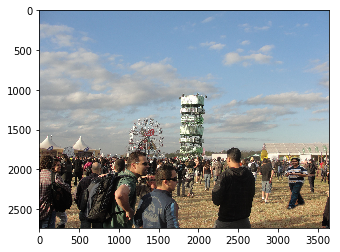

In [0]:
plt.imshow(arr)

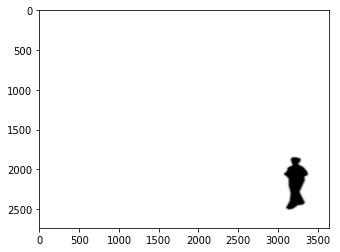

In [0]:
# Mask applied
arr=imread('dataset-dist/phase-01/training/fake/'+'092b43f88eab0ae3ecc0eb0ccbe37c82.mask.png')
plt.imshow(arr)

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given image need to predict if it is fake or not. </p>

In [0]:
print('Number of fake images = {}'.format((len(os.listdir('dataset-dist/phase-01/training/fake/'))-1)/2)) # the folder contains both fake image and its mask
print('Number of pristine images = {}'.format((len(os.listdir('dataset-dist/phase-01/training/pristine/')))))

Number of fake images = 450.0
Number of pristine images = 1050


### Data (IMAGE) Preprocessing

**remove .ds_store**

In [0]:
import os        
def delete_dstore(items,items_path):
    for item in items:
        if item == ".DS_Store":
#             print(item)
            os.remove(os.path.join(items_path, item))

In [0]:
fakes = os.listdir(fake_path)[1:]
pristines = os.listdir(pristine_path)

delete_dstore(fakes,fake_path)
#print(delete_dstore(fakes,fake_path))
# print(delete_dstore(pristines,pristine_path))

In [0]:
fakes = os.listdir(fake_path)[1:]
pristines = os.listdir(pristine_path)[1:]

In [0]:
".DS_Store" in fakes

False

In [0]:
fakes[:10] # mask followed by image

['e44cb44a7cf02f5c4f9f4c2f0f62f3ce.mask.png',
 'bb24d8980818339d65bb77a978b0f4ad.png',
 'a67721b7b84cb6e9649c67168d02274b.mask.png',
 '95545cc4da4cae23ec42672bbbd3bfa7.png',
 'bb7ed6b43f565a1fe2ebcbf99886d1d4.png',
 'b5b7caee2a885e16b9b71e2345fb468f.mask.png',
 'cb73316904b4dfa07e2f0066fdc91242.mask.png',
 'baa105757f53efb5355ed8690994de83.png',
 '207763f02c2c5881c898386782da1728.mask.png',
 'd4e7b59257c600b426046bed3a7da516.png']

In [0]:
pristines[:10]

['0cd3336bcf6da64100be66bd613d493c.png',
 '6f556b2583701fb343a5aca946dd71dd.png',
 '4c15ec243178e6fea3390f17b1c0070c.png',
 '0e53cd9ad8eeb7e42730e80624a3a0dc.png',
 '5fb090a35bfa08776c41e854d6d274ca.png',
 '1dd0c70dc732df85cae56497a7a8c28b.png',
 '5b258f62113b68d48e0dfaf57cbfb0e7.png',
 '4de1b83e6183b9253aa82f5dfd214811.png',
 '3d85fc8acc66dfa9a4b23f4dcc88d179.png',
 '5a35fdfa9e55ca28fc70cc73f34b3df6.png']

In [0]:
# segregate masks from images
#create mask folder under fake folder

# if not os.path.isdir(fake_path+'masks/'):
#     os.mkdir(fake_path+'masks/')
#     for fake in fakes:
#         if len(fake.split('.'))==3:
#             shutil.move(fake_path+fake, fake_path+'masks/')
# else:
#     print('Segregated already')


if not os.path.isdir(mask_path+'masks/'):
    os.mkdir(mask_path+'masks/')
    for fake in fakes:
        if len(fake.split('.'))==3:
            shutil.move(fake_path+fake, mask_path+'masks/')
else:
    print('Segregated already')

In [0]:
# shutil.rmtree(fake_path+'masks/')
# print(os.listdir(fake_path+'masks/')[1:-1])

###  Image shape fake images

In [0]:
fakes = os.listdir(fake_path)[1:-1]
print(fakes)
print("total fake images",len(fakes))

['bb24d8980818339d65bb77a978b0f4ad.png', '95545cc4da4cae23ec42672bbbd3bfa7.png', 'bb7ed6b43f565a1fe2ebcbf99886d1d4.png', 'baa105757f53efb5355ed8690994de83.png', 'd4e7b59257c600b426046bed3a7da516.png', 'ad858c2668b85ebaaed311e1fe56b01d.png', 'ca8f5bc4dfc11f10d823230e1c800caf.png', '229f447c1a26a74005b3f058201bde3f.png', 'bc04da26ab41ce92565dd3c686dae6c8.png', 'c6d6089b4ea367333ca025d8cd1c8d33.png', 'c890621aeaafe9b0e353f29a7d93391d.png', 'd7632c418ab10443dbeddc264ec032fb.png', 'ae9dbc1d83a6063f921c7b6f19ecc468.png', 'b36e7a5450bf93dfa0484d22c6bab840.png', 'b21ec9c8f63bb394181430af882a8a99.png', 'b2474c062971986f588459818c212a8c.png', 'b39a55c7b0c32dcbc7af93412413bb71.png', 'cbf729aea39780adc2e5a7a23c8f5c21.png', 'd0122ee951d52ee1198b9c402c0a75bf.png', 'b47c970b9a25c103951ab48c55727ecc.png', '86186107aac2418722572c5632f01ade.png', 'd13e3749938f9bcd3945bed229d40bb7.png', 'aa26ed5cf3896639bca34b372a774c4e.png', 'aa61a96b0a18b8dbc65fd20af3644958.png', 'a3902e315de94e425dfd3bd109dc88de.png',

In [0]:
# #all_fakes
# import glob
# all_fakes = glob.glob(fake_path + "*.png")
# #print(all_fakes) 
# for fake in fakes:
#     fake_shapes.append(imread(fake_path+fake).shape)

In [0]:
fake_shapes=[]                      
for fake in fakes:
    fake_shapes.append(imread(fake_path+fake).shape)

In [0]:
for i in range(20):
    ind=np.random.randint(0, len(fake_shapes))
    print(str(ind) +'\t'+ str(fake_shapes[ind]) +'\t'+fakes[ind])

148	(768, 1024, 3)	b97db18acbee83be9760fb8eb8661652.png
251	(768, 1024, 3)	aab5d03983b5d585608d8ff863f7b3fb.png
165	(1536, 2048, 4)	31682dc53f670f43d4308f7e99a1d3f8.png
391	(768, 1024, 3)	daa767cd9cc041a3b7a340528689adab.png
357	(768, 1024, 3)	8812398ed09ccb906f4e0d608aec0913.png
278	(1944, 2592, 3)	cb5dece724ab947f6a615c7fe1f8c380.png
334	(768, 1024, 3)	c86cb7e7cf51b7b182a6ffa8b253ed2b.png
203	(768, 1024, 3)	b835388bf7843d20544c6de90d11c51c.png
397	(768, 1024, 3)	c414179415b146d9cbeca0fb3fb351a7.png
276	(771, 1024, 3)	cb4d47e95b84ec3eee1796bc8fff1180.png
7	(4288, 3216, 3)	229f447c1a26a74005b3f058201bde3f.png
3	(765, 1024, 3)	baa105757f53efb5355ed8690994de83.png
18	(768, 1024, 3)	d0122ee951d52ee1198b9c402c0a75bf.png
246	(768, 1024, 3)	c3cd547094fa52e65a22228bba5ef189.png
268	(768, 1024, 3)	d40f3ba9fd4d86bd79dd02a5104c16c1.png
358	(768, 1024, 3)	cdce0701fa96db632af5facf074fe654.png
292	(768, 1024, 3)	c328943933b839c4f9d2d0c94a831eab.png
162	(768, 1024, 4)	d531b1cefbdd804a28399c46965aba5

Some fake images have 4 channels

In [0]:
for fake in fakes:
    if fake.endswith('.png'):
        if imread(fake_path+fake).shape[2]>4:
            print('5 channels in image ' + fake)

In [0]:
for fake in fakes:
    if imread(fake_path+fake).shape[2]<3:
        print('Less than 3 channels in image ' + fake)

In [0]:
for fake in fakes:
    if len(imread(fake_path+fake).shape)<=2:
        print(fake)

All images have 4 or 3 channels

In [0]:
four_channel_fakes=[]
for fake in fakes:
    if imread(fake_path+fake).shape[2]==4:
        four_channel_fakes.append(fake)
        
three_channel_fakes = [f for f in fakes if f not in four_channel_fakes]

In [0]:
print("four_channel_fakes",len(four_channel_fakes))
print("three_channel_fakes",len(three_channel_fakes))

four_channel_fakes 63
three_channel_fakes 385


In [0]:
heights=[]
widths=[]

for fake in fakes:
    img=imread(fake_path+fake)
    heights.append(img.shape[0])
    widths.append(img.shape[1])

In [0]:
print('minimum height = {}'.format(min(heights)))
print('maximum height = {}'.format(max(heights)))

print('minimum width = {}'.format(min(widths)))
print('maximum width = {}'.format(max(widths)))

minimum height = 480
maximum height = 4288
minimum width = 640
maximum width = 4320


###  Image shape masks

In [0]:
masks = os.listdir(mask_path1)

In [0]:
len(masks)

450

In [0]:
mask_shapes=[]
for mask in masks:
    mask_shapes.append(imread(mask_path1+mask).shape)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [0]:
for i in range(20):
    ind=np.random.randint(0, len(mask_shapes))
    print(str(ind) +'\t'+ str(mask_shapes[ind]) +'\t'+masks[ind])

153	(768, 1024)	b9988711e0a2880bb4fa8cf549dc55bc.mask.png
229	(768, 1024)	b300897bc8a566bb9e806d8132e25f5b.mask.png
342	(2112, 2816, 3)	2472627d9b38bce396254ac17b9b3655.mask.png
200	(768, 1024)	bd993ecb7172acc9508e2d74fa239e6c.mask.png
367	(3240, 4320, 3)	6743af3f663bc4244b0f80b93541f542.mask.png
126	(598, 848, 3)	ca472f184807aded538221ac0b5ac27b.mask.png
274	(768, 1024)	ce5cd74980494117a495a305ed5fe95b.mask.png
266	(2748, 3664, 3)	a9667850a5652972443b765ae3ccf3ff.mask.png
24	(1536, 2048, 4)	839128f5837a4d3614e9f1f6b4cf087e.mask.png
195	(768, 1024)	cfb77b3822d05b280d51e8259f0c2ff4.mask.png
314	(768, 1024)	da51285c1f90d4b22b4be4e9d0ac63aa.mask.png
84	(768, 1024)	bcbc7bef972e1b0ad0ebf8d4781aba31.mask.png
156	(768, 1024)	bac7fb0f429c30179ca36411f11713ed.mask.png
438	(768, 1024)	b46123b02139d593c1f842bc46ddc634.mask.png
52	(1536, 2048, 4)	906607152d984039c6baebdf6fa15c40.mask.png
194	(4000, 3000, 3)	588da262d375acd1ee48212fb2760ae2.mask.png
40	(768, 1024)	a20985daaeef78ec36b75a820360ee7e.m

In [0]:
for mask in masks:
    img=imread(mask_path1+mask)
    if len(img.shape)>2 and img.shape[2]>4:
        print('More than 4 channels in image ' + mask)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [0]:
for mask in masks:
    img=imread(mask_path1+mask)
    if len(img.shape)>2 and img.shape[2]<3:
        print('Less than 3 channels in image ' + mask)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [0]:
one_channel_masks=[]
for mask in masks:
    if len(imread(mask_path1+mask).shape)==2:
        one_channel_masks.append(mask)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [0]:
three_channel_masks=[]
for mask in masks:
    img=imread(mask_path1+mask)
    if len(img.shape)==3 and img.shape[2]==3:
        three_channel_masks.append(mask)

four_channel_masks=[m for m in masks if ((m not in one_channel_masks) and (m not in three_channel_masks))]

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [0]:
print("three_channel_masks",len(three_channel_masks))
print("four_channel_masks",len(four_channel_masks))
print(str(len(one_channel_masks))+' masks have only one channel i.e. grayscale')

three_channel_masks 65
four_channel_masks 55
330 masks have only one channel i.e. grayscale


**All masks have 1, 3 or 4 channels**

In [0]:
heights=[]
widths=[]

for mask in masks:
    img=imread(mask_path1+mask)
    heights.append(img.shape[0])
    widths.append(img.shape[1])

print('minimum height = {}'.format(min(heights)))
print('maximum height = {}'.format(max(heights)))

print('minimum width = {}'.format(min(widths)))
print('maximum width = {}'.format(max(widths)))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


minimum height = 480
maximum height = 4288
minimum width = 640
maximum width = 4320


In [0]:
i=0
for mask, fake in tqdm_notebook(zip(masks, fakes)):
    mask_img=imread(mask_path1+mask)
    fake_img=imread(fake_path+fake)
    if mask_img.shape[:2]!=fake_img.shape[:2]:
        i+=1
        print(str(mask_img.shape)+' '+str(fake_img.shape))

(750, 1000) (771, 1024, 3)
(768, 1024) (2304, 3072, 3)
(768, 1024) (1536, 2048, 3)
(1067, 1600) (765, 1024, 3)
(1536, 2048, 4) (806, 1075, 3)
(1536, 2048, 4) (768, 1024, 3)
(1200, 1600, 3) (765, 1024, 3)
(768, 1024) (4288, 3216, 3)
(1000, 1504) (768, 1024, 3)
(765, 1024) (768, 1024, 4)
(972, 1296) (768, 1024, 3)
(768, 1024) (1200, 1600, 3)
(765, 1024) (768, 1024, 3)
(1536, 2048, 4) (768, 1024, 3)
(2304, 3072, 3) (768, 1024, 3)
(3240, 4320, 3) (768, 1024, 3)
(768, 1024) (600, 800, 4)
(1536, 2048, 4) (768, 1024, 3)
(3240, 4320, 3) (771, 1024, 3)
(1200, 1800, 4) (1536, 2048, 3)
(1536, 2048, 4) (768, 1024, 3)
(1200, 1600) (768, 1024, 3)
(1536, 2048, 4) (768, 1024, 3)
(771, 1024) (3240, 4320, 3)
(768, 1024) (778, 1037, 3)
(765, 1024) (771, 1024, 3)
(2736, 3648, 3) (765, 1024, 3)
(768, 1024) (691, 922, 3)
(768, 1024) (2048, 1536, 3)
(768, 1024) (771, 1024, 3)
(1286, 1709) (2748, 3664, 3)
(2304, 3072, 3) (768, 1024, 3)
(768, 1024) (2144, 2848, 3)
(768, 1024) (1536, 2048, 4)
(771, 1024) (1000,

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


(771, 1024) (768, 1024, 3)
(3240, 4320, 3) (768, 1024, 3)
(1067, 1600) (768, 1024, 3)
(595, 1025) (3240, 4320, 3)
(1536, 2048, 4) (1944, 2592, 3)
(3240, 4320, 3) (1536, 2048, 4)
(1536, 2048, 4) (563, 798, 4)
(1536, 2048, 4) (2112, 2816, 3)
(765, 1024) (768, 1024, 3)
(768, 1024) (1200, 1600, 3)
(778, 1037) (1944, 2592, 3)
(768, 1024) (648, 1152, 3)
(3240, 4320, 3) (1072, 1424, 3)
(771, 1024) (768, 1024, 3)
(768, 1024) (2848, 4272, 3)
(1536, 2048, 4) (765, 1024, 3)
(1024, 768) (768, 1024, 3)
(3000, 4000, 3) (1200, 1600, 3)
(768, 1024) (1536, 2048, 4)
(1920, 2560, 3) (768, 1024, 3)
(3240, 4320, 3) (768, 1024, 4)
(768, 1024) (3216, 4288, 3)
(2144, 2848, 3) (768, 1024, 4)
(768, 1024) (1536, 2048, 3)
(3000, 4000, 3) (768, 1024, 3)
(1536, 2048, 4) (768, 1024, 3)
(2748, 3664, 3) (2592, 1936, 3)
(3216, 4288, 3) (1536, 2048, 3)
(3240, 4320) (768, 1024, 3)
(771, 1024) (768, 1024, 3)
(806, 1075) (768, 1024, 4)
(1200, 1600) (1536, 2048, 4)
(768, 1024) (806, 1075, 3)
(2048, 1536, 4) (1536, 2048, 4)


### 3.3. Image shape pristines

In [0]:
pristine_shapes=[]
for pristine in pristines:
    pristine_shapes.append(imread(pristine_path+pristine).shape)

In [0]:
print("total pristine images",len(pristines))

total pristine images 1049


In [0]:
for i in range(20):
    ind=np.random.randint(0, len(pristine_shapes))
    print(str(ind) +'\t'+ str(pristine_shapes[ind]) +'\t'+pristines[ind])

15	(575, 1024, 3)	6a7ff6587ff54c98c4ae74e6919ba872.png
960	(683, 1024, 3)	2d19143b8df9a2b09c06443a6e9e8f48.png
903	(768, 1024, 3)	4bf3f6c258465d85d004196b0dc07238.png
112	(768, 1024, 3)	5aced0ab3e06a9428cf54767cd5b8df6.png
239	(768, 1024, 3)	0cff314c97cc71a8829c9634033c7b5d.png
283	(768, 1024, 3)	6e91f788bd7f03474fb5f7174ee3b4fe.png
855	(768, 1024, 3)	3dc169ca1c6fac15eb894ea4070b3354.png
979	(768, 1024, 3)	4d3e8361ef33681f61908515665c7c94.png
301	(768, 1024, 3)	3b74f3fda8320ddf906ae86e4709ede2.png
341	(768, 1024, 3)	2ae1c3e6cafa5d97b7e3e52f5bfaf746.png
584	(768, 1024, 3)	2f8b0583814f166db8837f735b3f0da2.png
301	(768, 1024, 3)	3b74f3fda8320ddf906ae86e4709ede2.png
41	(768, 1024, 3)	6dfe289308c88d6eb90432660aafb733.png
392	(768, 1024, 3)	3dfd63f3e4d34de1091bebba86e46ad2.png
210	(768, 1024, 3)	3e332273390c4669a74e9230f243f7b7.png
709	(768, 1024, 3)	0ec68b5855d7d9b48178f658fd7bb6ef.png
153	(575, 1024, 3)	3dc028ca0e2f3710995b4a253ac2745c.png
866	(768, 1024, 3)	1bdacf031df6961e50e1594a83f3ae9

In [0]:
three_channel_pristines=[]

for pristine in pristines:
    img=imread(pristine_path+pristine)
    if len(img.shape)==3 and img.shape[2]==3:
        three_channel_pristines.append(pristine)

In [0]:
one_channel_pristines=[]

for pristine in pristines:
    img=imread(pristine_path+pristine)
    if len(img.shape)<3:
        one_channel_pristines.append(pristine)
    
four_channel_pristines=[p for p in pristines if (p not in one_channel_pristines) and (p not in three_channel_pristines)]

In [0]:
print("one_channel_pristines",len(one_channel_pristines))
print("three_channel_pristines",len(three_channel_pristines))
print("four_channel_pristines",len(four_channel_pristines))

one_channel_pristines 3
three_channel_pristines 1024
four_channel_pristines 22


In [0]:
for pristine in one_channel_pristines:
    img=imread(pristine_path+pristine)
    print(img.shape)

(768, 1024)
(768, 1024)
(768, 1024)


In [0]:
heights=[]
widths=[]

for pristine in pristines:
    img=imread(pristine_path+pristine)
    heights.append(img.shape[0])
    widths.append(img.shape[1])

print('minimum height = {}'.format(min(heights)))
print('maximum height = {}'.format(max(heights)))

print('minimum width = {}'.format(min(widths)))
print('maximum width = {}'.format(max(widths)))

minimum height = 575
maximum height = 768
minimum width = 576
maximum width = 1024


In [0]:
table={}
table['pristines']=[3, 1024, 22, 1049]
table['fakes']=[0, 385, 63, 448]
table['masks']=[330, 65, 55, 450]
pd.DataFrame(table, index=['1 channel', '3 channel', '4 channel', 'total'])

,pristines,fakes,masks
1 channel,3,0,330
3 channel,1024,385,65
4 channel,22,63,55
total,1049,448,450


#### Only use 3 channel pristines, discard 1 and 4 channel images

In [0]:
four_channel_image = imread(pristine_path+four_channel_pristines[21])

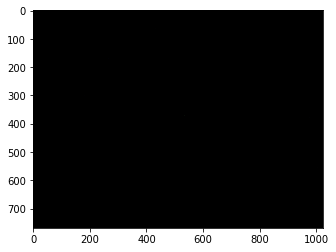

In [0]:
plt.imshow(four_channel_image)

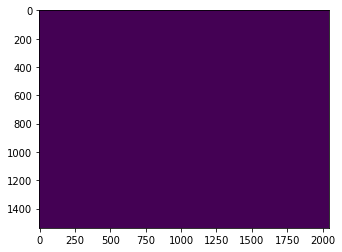

In [0]:
four_channel_image = imread(fake_path+four_channel_fakes[49])
plt.imshow(four_channel_image[:,:,3])

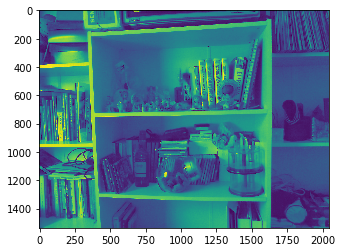

In [0]:
plt.imshow(four_channel_image[:,:,2])

In [0]:
four_channel_image = imread(mask_path1+four_channel_masks[54])

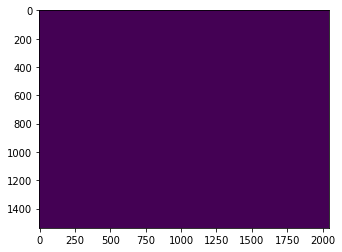

In [0]:
plt.imshow(four_channel_image[:,:,3])

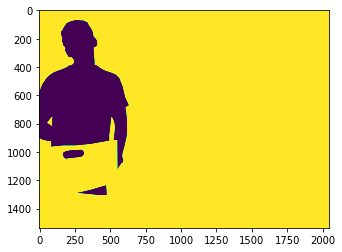

In [0]:
plt.imshow(four_channel_image[:,:,2])

 **The feature engineering phase requires only one channel information. The same information is duplicated across other 2 channels**
 
 **For pristines: Discard channel 1 and 4, akes only channel 3
 For fakes: Discard channel 1 and 4, takes only channel 3
 For masks: Discard channel 3 and 4, takes only channel 1**

### Checkpoint 1 (saving the image list using pickle)

In [0]:
with open('one_channel_pristines.pickle', 'wb') as f:
    pickle.dump(one_channel_pristines, f)
    
with open('three_channel_pristines.pickle', 'wb') as f:
    pickle.dump(three_channel_pristines, f)

with open('four_channel_pristines.pickle', 'wb') as f:
    pickle.dump(four_channel_pristines, f)
    
with open('three_channel_fakes.pickle', 'wb') as f:
    pickle.dump(three_channel_fakes, f)
    
with open('four_channel_fakes.pickle', 'wb') as f:
    pickle.dump(four_channel_fakes, f)

with open('one_channel_masks.pickle', 'wb') as f:
    pickle.dump(one_channel_masks, f)
    
with open('three_channel_masks.pickle', 'wb') as f:
    pickle.dump(three_channel_masks, f)
    
with open('four_channel_masks.pickle', 'wb') as f:
    pickle.dump(four_channel_masks, f)

#### loading the image list

In [0]:
with open('one_channel_pristines.pickle', 'rb') as f:
    one_channel_pristines = pickle.load(f)
    
with open('three_channel_pristines.pickle', 'rb') as f:
    three_channel_pristines = pickle.load(f)

with open('four_channel_pristines.pickle', 'rb') as f:
    four_channel_pristines=pickle.load(f)
    
with open('three_channel_fakes.pickle', 'rb') as f:
    three_channel_fakes=pickle.load(f)
    
with open('four_channel_fakes.pickle', 'rb') as f:
    four_channel_fakes=pickle.load(f)

with open('one_channel_masks.pickle', 'rb') as f:
    one_channel_masks=pickle.load(f)
    
with open('three_channel_masks.pickle', 'rb') as f:
    three_channel_masks=pickle.load(f)
    
with open('four_channel_masks.pickle', 'rb') as f:
    four_channel_masks=pickle.load(f)

In [6]:
print(len(three_channel_pristines))
print(len(three_channel_fakes))
print(len(one_channel_masks))

1024
385
330


After all data cleaning we have :
- 1024 pristine images (3 channels)
- 385 fake images (3 channels)
- 330 masks (1 channel)

**masks will be used to sample image patches for creation of train and cv data (label = fake) to be fed into CNN. This ensures that CNN learns boundaries created due to forgery operations because of change in statistics of underlying image at these boundaries**

### Dataset preparation

### Concatenate pristine and fake images

In [0]:
# pristines_final=[]
# for pristine in pristines:
#     img=imread(pristine_path+pristine)
#     if len(img.shape)<3:
#         continue
#     if img.shape[2]==4:
#         continue
#     pristines_final.append(pristine)

# print(len(pristines_final))

In [0]:
# fake_images=[]
# fakes_final=[]
# for fake in fakes:
#     img=imread(fake_path+fake)
#     try:
#         fake_images.append(img[:,:,:3])
#         fakes_final.append(fake)
#     except IndexError:
#         print('image {fake} has only 1 channel')
        
# print(len(fakes_final))

In [0]:
# image_names=[]
# for i in range(0, len(pristines_final)):
#     image_names.append(pristines_final[i])
# for i in range(0, len(fake_images)):
#     image_names.append(fakes_final[i])

In [0]:
# len(image_names)

1472

In [7]:
image_names = []
image_names.extend(three_channel_pristines)
image_names.extend(three_channel_fakes)
print(len(image_names))

1409


### Train test split

We have 1025 pristine images and 450 fake images. Since no timestamp has been given we resort to random splitting.<br>
80% train, 20% test

In [0]:
# labels=[0]*1025+[1]*450
labels=[0]*1024+[1]*385

In [0]:
x_train, x_test, y_train, y_test = train_test_split(image_names, labels, test_size=0.2, stratify=labels)

### Feature engineering on train set

As suggested in https://ieeexplore.ieee.org/abstract/document/7823911 we will extract image patches from training images both from pristine and fake images. First we will use masks to sample fake images at boundaries. These will be labeled as fake images. Then same number of patches will be sampled from pristine images to ensure a balanced dataset

In [10]:
%%time
x_train_images=[]
for x in x_train:
    try:
        img=imread(pristine_path+x)
    except FileNotFoundError:
        img=imread(fake_path+x)
    
    x_train_images.append(img)

CPU times: user 50.1 s, sys: 5.44 s, total: 55.6 s
Wall time: 11min 42s


In [0]:
heights=[]
widths=[]

for image in x_train_images:
    heights.append(image.shape[0])
    widths.append(image.shape[1])

In [12]:
print("max(heights)",max(heights))
print("min(heights)",min(heights))
print("max(widths)",max(widths))
print("min(widths)",min(widths))

max(heights) 4288
min(heights) 575
max(widths) 4320
min(widths) 792


In [12]:
%%time
x_train_mask_names=[]
for ind, x in enumerate(x_train):
    if y_train[ind]==1:
        x_train_mask_names.append(x.split('.')[0]+'.mask.png')

print(len(x_train_mask_names))

308
CPU times: user 2.04 ms, sys: 2 µs, total: 2.04 ms
Wall time: 1.41 ms


In [13]:
%%time
x_train_fakes_names=[]
x_train_fake_images=[]
for ind, x in enumerate(x_train):
    if y_train[ind]==1:
        x_train_fakes_names.append(x)
        x_train_fake_images.append(x_train_images[ind])

print(len(x_train_fake_images))

308
CPU times: user 386 µs, sys: 935 µs, total: 1.32 ms
Wall time: 1.05 ms


In [14]:
%%time
x_train_pristines_names=[]
x_train_pristine_images=[]
for ind, x in enumerate(x_train):
    if y_train[ind]==0:
        x_train_pristines_names.append(x)
        x_train_pristine_images.append(x_train_images[ind])

print(len(x_train_pristine_images))

819
CPU times: user 1.68 ms, sys: 83 µs, total: 1.76 ms
Wall time: 1.34 ms


In [15]:
%%time
x_train_masks=[]
for m in x_train_mask_names:
    img=imread(mask_path1+m)
    if len(img.shape)>2:
        img=img[:,:,0]
    x_train_masks.append(img)

print(len(x_train_masks))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


308
CPU times: user 12.2 s, sys: 1.56 s, total: 13.8 s
Wall time: 3min


In [0]:
x_train_fake_images[0].shape

(771, 1024, 3)

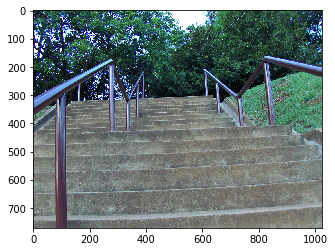

In [0]:
plt.imshow(x_train_fake_images[0][:,:,:3])

In [16]:
heights=[]
widths=[]

for image in x_train_masks:
    heights.append(image.shape[0])
    widths.append(image.shape[1])

print("max(heights)",max(heights))
print("min(heights)",min(heights))
print("max(widths)",max(widths))
print("min(widths)",min(widths))

max(heights) 4000
min(heights) 598
max(widths) 4320
min(widths) 792


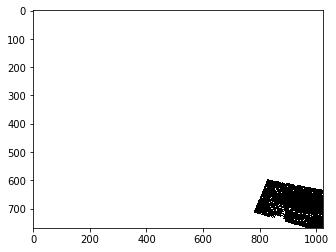

In [0]:
plt.imshow(x_train_masks[28], cmap='gray')

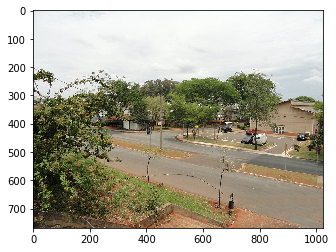

In [0]:
plt.imshow(x_train_fake_images[28])

**Convert grayscale images to binary**

In [17]:
%%time
binaries=[]

for grayscale in x_train_masks:
    blur = cv2.GaussianBlur(grayscale,(5,5),0)
    ret,th = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    binaries.append(th)

CPU times: user 5.32 s, sys: 2.01 s, total: 7.33 s
Wall time: 3.02 s


In [18]:
~binaries[28]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

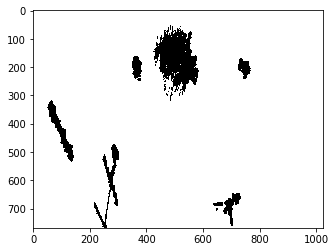

In [24]:
plt.imshow(binaries[28], cmap='gray')

In [0]:
mask_pixels = [np.count_nonzero(~binaries[i]) for i in range(len(binaries))]

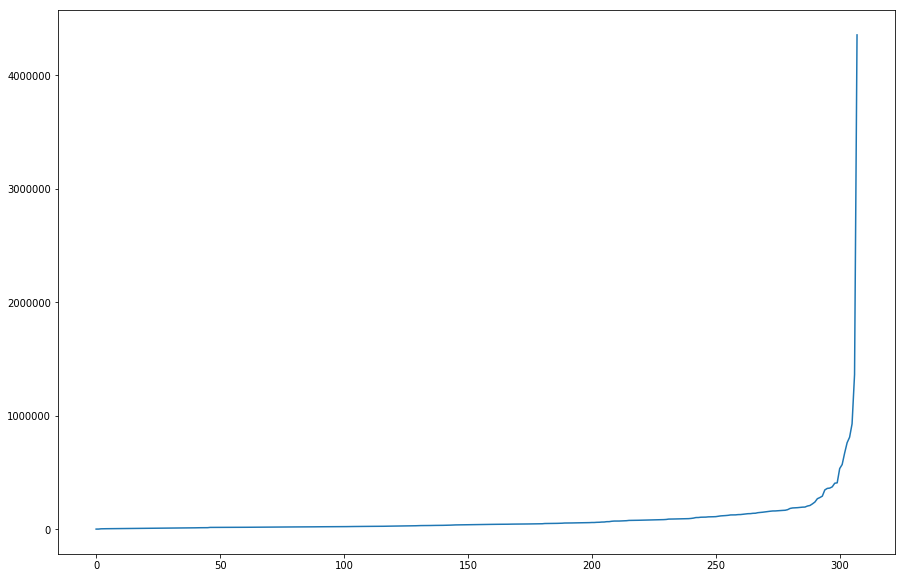

In [0]:
rcParams['figure.figsize']=15,10
plt.plot(sorted(mask_pixels))

In [0]:
0.25*64*64

1024.0

In [31]:
0.4*64*64

1638.4

In [0]:
np.percentile(sorted(mask_pixels), np.arange(.1,1,.1))

array([1369.7  , 1400.4  , 1431.1  , 1972.064, 2689.83 , 3407.596,
       3899.478, 4151.832, 4404.186])

**We must capture information from every image. We use patch size of 64 * 64 and ensuring minimum 40% contribution from forged area and authentic area.<br>This ensures that more than 99% of masks are covered including discriminative boundary at the same time**

In [0]:
# def count_255(mask):
#     i=0
#     for row in range(mask.shape[0]):
#         for col in range(mask.shape[1]):
#             if mask[row,col]==255:
#                 i+=1
#     return i

def count_255(mask):
    b = mask
    b[np.where(mask==255)] = 1
    return np.sum(b)

In [0]:
def sample_fake(img, mask, kernel_size=64, stride=32, per_area=1600):
#     kernel_size=64
#     stride=8
      #per_area=1024
    samples=[]
#     counter =0
    for y_start in range(0, img.shape[0]-kernel_size+1, stride):
        for x_start in range(0, img.shape[1]-kernel_size+1, stride):
            c_255=count_255(mask[y_start:y_start+kernel_size, x_start:x_start+kernel_size])
            if (c_255>per_area) and (kernel_size*kernel_size-c_255>per_area):
                samples.append(img[y_start:y_start+kernel_size, x_start:x_start+kernel_size, :3])    
#         counter += 1
    return samples

In [22]:
%%time
sample=sample_fake(x_train_fake_images[8], x_train_masks[8])
len(sample)

CPU times: user 63.6 ms, sys: 1.01 ms, total: 64.6 ms
Wall time: 62.4 ms


In [0]:
x_train_fake_images[8].shape

(768, 1024, 3)

In [0]:
x_train_masks[8].shape

(768, 1024)

In [0]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

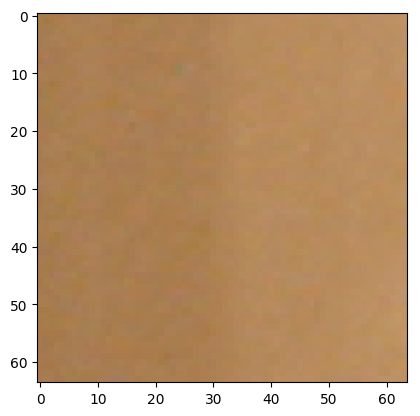

In [0]:
plt.imshow(sample[2])

In [0]:
len(x_train_fake_images)

308

**Checkpoint 2**

In [0]:
%%time
with open('data/x_train_fake_images.pickle', 'wb') as f:
    pickle.dump(x_train_fake_images, f)

with open('data/x_train_images.pickle', 'wb') as f:
    pickle.dump(x_train_images, f)
        
with open('data/x_train_pristine_images.pickle', 'wb') as f:
    pickle.dump(x_train_pristine_images, f)

In [0]:
# locals() #delete from disks

In [38]:
%%time

def samples_generator(x_train_fake_images, x_train_masks, kernel_size, stride, per_area):
  samples_fake=[]
  i=0
  for fake, mask in zip(x_train_fake_images, x_train_masks):
      image_samples=sample_fake(fake, mask, kernel_size, stride, per_area)
      for sample in image_samples:
        #print(sample)
        samples_fake.append(sample)
        i+=1
  
  return samples_fake

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


In [34]:
samples_fake_grayscale = samples_generator(x_train_fake_images, x_train_masks, kernel_size=64, stride=32, per_area=1600)
#kernel_size=64, stride=32, per_area=1600
len(samples_fake_grayscale)#3060

122849

In [0]:
samples_fake_binary = samples_generator(x_train_fake_images, x_train_masks, kernel_size=64, stride=8, per_area=1024)
len(samples_fake_binary) #122849

In [0]:
np.save('k64_grayscale_40percent_stride32/samples_fakes_np.npy', samples_fake_grayscale)
np.save('k64_binary_25percent_stride8/samples_fakes_np.npy', samples_fake_binary)

**run above code snippet one at a time and store sample_fakes to sample_fakes_np.npy k64 grayscale 40percent stride32/ and k64 binary 25percent stride8 respectively**

Above code is trivially parallelizable, check sample_fake.py and sample_fake_binaries.py

Using kernel size of 64 and stride of 32 produces about 4000 fake samples. Decreasing the stride generates a larger dataset of fake images. We try both stride=32 on grayscale images and stride=8 on binary images.

In [0]:
samples_fake_grayscale = np.load('k64_grayscale_40percent_stride32/samples_fakes_np.npy')
samples_fake_binary = np.load('k64_binary_25percent_stride8/samples_fakes_np.npy')

In [0]:
fake_samples_grayscale = samples_fake_grayscale.shape[0]
fake_samples_binary = samples_fake_binary.shape[0]

In [44]:
print(f'we have {fake_samples_grayscale} fake samples each of shape 64 * 64 using grayscale masks')
print(f'we have {fake_samples_binary} fake samples each of shape 64 * 64 using binary masks')

we have 3060 fake samples each of shape 64 * 64 using grayscale masks
we have 122849 fake samples each of shape 64 * 64 using binary masks


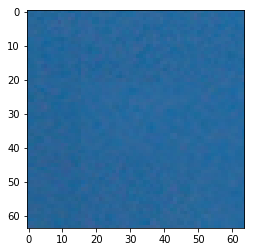

In [48]:
plt.imshow(samples_fake_grayscale[501])

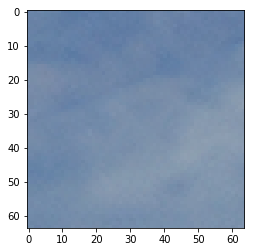

In [49]:
plt.imshow(samples_fake_binary[120000])

Now to create negative samples we randomly sample 64 * 64 patches from authentic images

In [0]:
def sample_random(img, num_samples, stride=8):
    kernel_size=64
    
    x_start=0
    y_start=0
    samples=[]
    
    for y_start in range(0, img.shape[0] - kernel_size + 1, stride):
        for x_start in range(0, img.shape[1] - kernel_size + 1, stride):
            #c_255 = count_255(mask[y_start:y_start + kernel_size, x_start:x_start + kernel_size])
            #if (c_255 > threshold) and (kernel_size * kernel_size - c_255 > threshold):
            samples.append(img[y_start:y_start + kernel_size, x_start:x_start + kernel_size, :3])

    indices=np.random.randint(0, len(samples), min(len(samples), num_samples))
    
    sampled=[]
    for i in indices:
        sampled.append(samples[i])
    
    return sampled

In [0]:
# some images have all pixels=0 those images have been manually deleted

In [51]:
len(x_train_pristine_images)

819

In [52]:
len(x_train_fake_images)

308

In [54]:
3060/819

3.7362637362637363

In [55]:
4*819

3276

6 samples per pristine image

In [60]:
samples_pristine_grayscale=np.ndarray(shape=(3276, 64, 64, 3), dtype=np.dtype('uint8'))

i=0
for pristine_img in x_train_pristine_images:
    
    samples=sample_random(pristine_img, 4, stride=32)
    for sample in samples:
        samples_pristine_grayscale[i, :, :, :]=sample
        i+=1
print(i)

3276


In [57]:
len(x_train_pristine_images)

819

In [58]:
122849/819

149.998778998779

In [59]:
149*819

122031

217 samples per pristine image

In [61]:
%%time
samples_pristine_binary=np.ndarray(shape=(122031, 64, 64, 3), dtype=np.dtype('uint8'))

i=0
for pristine_img in x_train_pristine_images:
    
    samples=sample_random(pristine_img, 149)
    for j, sample in enumerate(samples):
        samples_pristine_binary[i, :, :, :]=sample
        i+=1
print(i)

122031


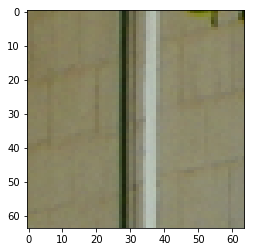

In [67]:
plt.imshow(samples_pristine_grayscale[3275])

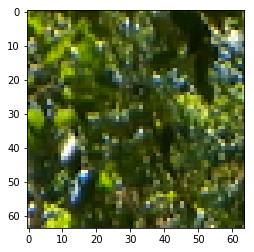

In [66]:
plt.imshow(samples_pristine_binary[122030])

In [68]:
print(f'number of fake samples in\n1. binary mask extraction using stride of 8 = {len(samples_fake_binary)}\n\
2. in grayscale mask extraction using stride of 32 = {len(samples_fake_grayscale)}\n\n\
number of pristine samples in\n1. binary mask extraction using stride of 8 = {len(samples_pristine_binary)}\n\
2. in grayscale mask extraction using stride of 32 = {len(samples_pristine_grayscale)}')

number of fake samples in
1. binary mask extraction using stride of 8 = 122849
2. in grayscale mask extraction using stride of 32 = 3060

number of pristine samples in
1. binary mask extraction using stride of 8 = 122031
2. in grayscale mask extraction using stride of 32 = 3276


In [0]:
train_labels_binary=[0]*len(samples_pristine_binary)+[1]*len(samples_fake_binary)
train_labels_grayscale=[0]*len(samples_pristine_grayscale)+[1]*len(samples_fake_grayscale)

### Checkpoint 2

x_train, x_test, y_train, y_test, samples_fake, samples_pristine, train_labels, x_train_fake_images, x_train_fakes_names, x_train_images, x_train_mask_names, x_train_masks, x_train_pristine_images, x_train_pristines_names

In [0]:
np.save('k64_grayscale_40percent_stride32/samples_pristine.npy', samples_pristine_grayscale)
np.save('k64_binary_25percent_stride8/samples_pristine.npy', samples_pristine_binary)

In [0]:
%%time
with open('data/x_train_fake_images.pickle', 'wb') as f:
    pickle.dump(x_train_fake_images, f)

# with open('data/x_train_images.pickle', 'wb') as f:
#     pickle.dump(x_train_images, f)
        
with open('data/x_train_pristine_images.pickle', 'wb') as f:
    pickle.dump(x_train_pristine_images, f)

In [0]:
for i in range(len(x_train_fake_images)):
    with open('data/x_train_fake_images_'+str(i)+'.pickle', 'wb') as f:
        pickle.dump(x_train_fake_images[i], f)

In [0]:
for i in range(len(x_train_images)):
    with open('data/x_train_images_'+str(i)+'.pickle', 'wb') as f:
        pickle.dump(x_train_images[i], f)

In [0]:
for i in range(len(x_train_pristine_images)):
    with open('data/x_train_pristine_images_'+str(i)+'.pickle', 'wb') as f:
        pickle.dump(x_train_pristine_images[i], f)

In [73]:
len(x_train_masks)

308

In [0]:
with open('data/x_train_masks_0.pickle', 'wb') as f:
    pickle.dump(x_train_masks[:50], f)

In [0]:
with open('data/x_train_masks_1.pickle', 'wb') as f:
    pickle.dump(x_train_masks[50:100], f)

In [0]:
with open('data/x_train_masks_2.pickle', 'wb') as f:
    pickle.dump(x_train_masks[100:150], f)

In [0]:
with open('data/x_train_masks_3.pickle', 'wb') as f:
    pickle.dump(x_train_masks[150:200], f)

In [0]:
with open('data/x_train_masks_4.pickle', 'wb') as f:
    pickle.dump(x_train_masks[200:250], f)

In [0]:
with open('data/x_train_masks_5.pickle', 'wb') as f:
    pickle.dump(x_train_masks[250:300], f)

In [0]:
# with open('x_train.pickle', 'wb') as f:
#     pickle.dump(x_train, f)

# with open('x_test.pickle', 'wb') as f:
#     pickle.dump(x_test, f)
    
# with open('y_train.pickle', 'wb') as f:
#     pickle.dump(y_train, f)

# with open('y_test.pickle', 'wb') as f:
#     pickle.dump(y_test, f)

# with open('samples_fake.pickle', 'wb') as f:
#     pickle.dump(samples_fake, f)

# with open('samples_pristine.pickle', 'wb') as f:
#     pickle.dump(samples_pristine, f)

with open('k64_binary_25percent_stride8/train_labels.pickle', 'wb') as f:
    pickle.dump(train_labels_binary, f)
    
with open('k64_grayscale_40percent_stride32/train_labels.pickle', 'wb') as f:
    pickle.dump(train_labels_grayscale, f)

with open('data/x_train_fakes_names.pickle', 'wb') as f:
    pickle.dump(x_train_fakes_names, f)

with open('data/x_train_mask_names.pickle', 'wb') as f:
    pickle.dump(x_train_mask_names, f)

with open('data/x_train_pristines_names.pickle', 'wb') as f:
    pickle.dump(x_train_pristines_names, f)

In [0]:
x_train_masks=[]
for i in range(6):
    with open('data/x_train_masks_'+str(i)+'.pickle', 'rb') as f:
        x_train_masks.extend(pickle.load(f))

In [0]:
with open('data/x_train_fakes_names.pickle', 'rb') as f:
    x_train_fakes_names=pickle.load(f)
    
x_train_fake_images=[]
for img in x_train_fakes_names:
    x_train_fake_images.append(imread(fake_path+img))

In [0]:
%%time
x_train_pristine_images=[]

with open('data/x_train_pristines_names.pickle', 'rb') as f:
    x_train_pristine_image_names=pickle.load(f)

for name in x_train_pristine_image_names:
    if os.path.isfile(pristine_path+name):
        x_train_pristine_images.append(imread(pristine_path+name))

In [0]:
samples_pristine_grayscale = np.load('k64_grayscale_40percent_stride32/samples_pristine.npy')
samples_fake_grayscale = np.load('k64_grayscale_40percent_stride32/samples_fakes_np.npy')

with open('k64_grayscale_40percent_stride32/train_labels.pickle', 'rb') as f:
    train_labels_grayscale = np.array(pickle.load(f))

In [0]:
samples_pristine_binary = np.load('k64_binary_25percent_stride8/samples_pristine.npy')
samples_fake_binary = np.load('k64_binary_25percent_stride8/samples_fakes_np.npy')

with open('k64_binary_25percent_stride8/train_labels.pickle', 'rb') as f:
    train_labels_binary = np.array(pickle.load(f))

In [99]:
samples_pristine_grayscale.shape

(3276, 64, 64, 3)

In [100]:
samples_fake_grayscale.shape

(3060, 64, 64, 3)

In [101]:
train_labels_grayscale.shape

(6336,)

In [102]:
samples_pristine_binary.shape

(122031, 64, 64, 3)

In [103]:
samples_fake_binary.shape

(122849, 64, 64, 3)

In [104]:
train_labels_binary.shape

(244880,)

In [0]:
# Concatenate authentic and fake image samples along axis=0 to generate train set for grayscale sampled images
train_data_grayscale = np.concatenate((samples_pristine_grayscale, samples_fake_grayscale), axis=0)

In [0]:
x_train, x_cv, y_train, y_cv = train_test_split(train_data_grayscale, train_labels_grayscale, test_size=0.3, stratify = train_labels_grayscale)

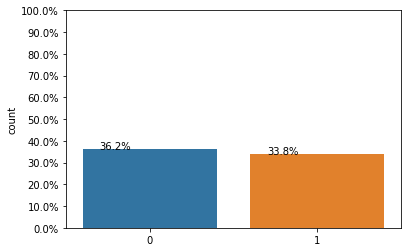

In [107]:
total = len(train_labels_grayscale)*1.
ax=sns.countplot(y_train)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

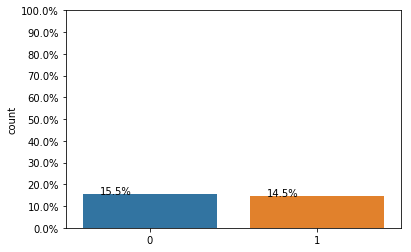

In [108]:
total = len(train_labels_grayscale)*1.
ax=sns.countplot(y_cv)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [0]:
if not os.path.isdir('k64_grayscale_40percent_stride32/train_data'):
    os.mkdir('k64_grayscale_40percent_stride32/train_data')
    
    np.save('k64_grayscale_40percent_stride32/train_data/x_train.npy', x_train)
    np.save('k64_grayscale_40percent_stride32/train_data/x_cv.npy', x_cv)
    
    np.save('k64_grayscale_40percent_stride32/train_data/y_train.npy', y_train)
    np.save('k64_grayscale_40percent_stride32/train_data/y_cv.npy', y_cv)
else:
    print('train data exists')

In [0]:
# Concatenate authentic and fake image samples along axis=0 to generate train set for binary sampled images
train_data_binary = np.concatenate((samples_pristine_binary, samples_fake_binary), axis=0)

In [0]:
x_train, x_cv, y_train, y_cv = train_test_split(train_data_binary, train_labels_binary, test_size=0.3, stratify = train_labels_binary)

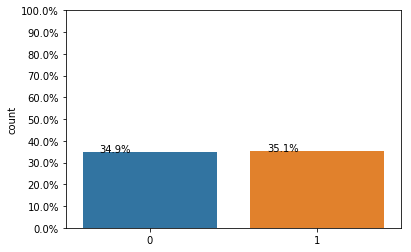

In [112]:
total = len(train_labels_binary)*1.
ax=sns.countplot(y_train)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

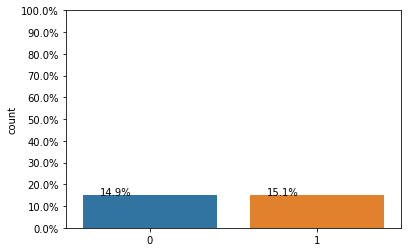

In [113]:
total = len(train_labels_binary)*1.
ax=sns.countplot(y_cv)
for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [0]:
if not os.path.isdir('k64_binary_25percent_stride8/train_data2'):
    os.mkdir('k64_binary_25percent_stride8/train_data2')
    
    np.save('k64_binary_25percent_stride8/train_data2/x_train.npy', x_train)
    np.save('k64_binary_25percent_stride8/train_data2/x_cv.npy', x_cv)
    
    np.save('k64_binary_25percent_stride8/train_data2/y_train.npy', y_train)
    np.save('k64_binary_25percent_stride8/train_data2/y_cv.npy', y_cv)
else:
    print('train data exists')

### Deep learning models

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Our CNN model must give log loss less than 0.89, accuracy more than 49.8%

<h3> 5.2. CNN architecture</h3>

In [0]:
import keras
from keras.models import load_model, Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications.resnet50 import ResNet50
from keras import applications
from keras import optimizers

In [118]:
x_test=np.load('k64_binary_25percent_stride8/x_test.npy')

y_test=np.load('k64_binary_25percent_stride8/y_test.npy')

FileNotFoundError: ignored

#### 5.2.1 VGG16

In [0]:
vgg_model=keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

model_aug=Sequential()
model_aug.add(vgg_model)

top_model=Sequential()
top_model.add(Flatten(input_shape=(2, 2, 512)))
#model_aug.add(Dropout(0.3))
top_model.add(Dense(64, activation='relu'))

top_model.add(Dense(1, activation='sigmoid'))

model_aug.add(top_model)

for layer in model_aug.layers[0].layers[:17]:
    layer.trainable=False

model_aug.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-3), metrics=['accuracy'])

print(model_aug.summary())

model_aug.fit(x_train, y_train, epochs=35, batch_size=32, validation_data=(x_cv, y_cv), verbose=1)
model_aug.save_weights('k64_binary_25percent_stride8/fine_tuned_model_adam_weights.h5')
        
# model_aug.load_weights('k64_binary_25percent_stride8/fine_tuned_model_adam_weights.h5')

W0814 19:21:39.498999 140503904368512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0814 19:21:39.511475 140503904368512 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 131201    
Total params: 14,845,889
Trainable params: 2,491,009
Non-trainable params: 12,354,880
_________________________________________________________________
None
Train on 171416 samples, validate on 73464 samples
Epoch 1/35
121536/171416 [====================>.........] - ETA: 13:51 - loss: 0.8274 - acc: 0.5364

In [0]:
# model_aug.summary()

In [0]:
# model_aug.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-6), metrics=['accuracy'])

In [0]:
model_aug.evaluate(x_test, y_test, verbose=0)

In [0]:
y_pred = model_aug.predict_classes(x_test)

In [0]:
plot_confusion_matrix(y_test, y_pred)

#### 5.2.2 ResNet50

In [119]:
resnet_model=ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

model_aug=Sequential()
model_aug.add(resnet_model)

top_model=Sequential()
top_model.add(Flatten(input_shape=(2, 2, 2048)))

top_model.add(Dense(64, activation='relu'))
# model_aug.add(Dropout(0.2))

top_model.add(Dense(1, activation='sigmoid'))

model_aug.add(top_model)

for layer in model_aug.layers[0].layers[:171]:
    layer.trainable=False

W0814 19:02:30.255833 140503904368512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 19:02:30.302339 140503904368512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 19:02:30.330919 140503904368512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0814 19:02:30.383421 140503904368512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0814 19:02:30.384892

94658560/94653016 [==============================] - 3s 0us/step


In [120]:
model_aug.load_weights('k64_binary_25percent_stride8/fine_tuned_model_64_adam_weights.h5')
# model_aug.load_weights('k64_binary_25percent_stride8/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

model_aug.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-3), metrics=['accuracy'])

OSError: ignored

In [0]:
model_aug.evaluate(x_test, y_test, verbose=0)

In [0]:
y_pred = model_aug.predict_classes(x_test)

In [0]:
# plot_confusion_matrix(y_test, y_pred)

In [0]:
model_aug.save( "message-classification-model.h5" )
!tar -zcvf message-classification-model.tgz message-classification-model.h5